# Programming for Chemistry 2025/2026 @ UniMI

![logo](logo_small.png "Logo")

## Lecture 17: Atomisitic Simulation Environment (ASE)

The Atomic Simulation Environment [ASE](https://ase-lib.org/) is a set of tools and Python modules for setting up, manipulating, running, visualizing and analyzing atomistic simulations.
Do you remember the `Molecule` class we developed in the previous lecture? ASE extends this concept to represent not only molecules but also periodic crystals, or low-dimensional systems like surfaces.

In addition to that, ASE provides interfaces to different codes through **Calculators** which are used together with the central Atoms object and the many available algorithms in ASE.
![calculators](ase_calculators.png "ASE Calculators")


ASE is:
* **Flexible:** Since ASE is based on the Python scripting language it is possible to perform very complicated simulation tasks without any code modifications. For example, a sequence of calculations may be performed with the use of simple *for-loop* constructions. There exist ASE modules for performing many standard simulation tasks.
* **Customizable:** The Python code in ASE is structured in modules intended for different purposes. There are `ase.calculators` for calculating energies, forces and stresses, `ase.md` and `ase.optimize` modules for controlling the motion of atoms, `constraints` objects and filters for performing `nudged-elastic-band` calculations etc. The modularity of the object-oriented code make it simple to contribute new functionality to ASE.
* **Pythonic:** It fits nicely into the rest of the Python world with use of the popular **NumPy** package for numerical work. The use of the Python language allows ASE to be used both interactively as well as in scripts.


## 1. Getting started with ASE
ASE can be imported by `import ase` and it's sub-packages like `import ase.io` or individual classes like `from ase.calculators.siesta import Siesta`. 

Since ASE depends heavily on NumPy, we need also to `import numpy as np`. If you have a C/C++ and a Fortran compiler, and optionally a MPI library (for parallel execution), you can also install `gpaw` and the `asap3` packages. The first provide a DFT-PAW *calculator*, the second provides empirical potentials for large scale molecular dynamics. Anyway, we can use the built-in `EMT` *calculator* in this notebook.  

ASE should be already installed in Anaconda. Under Linux/WSL you can install the official packages from your distribution. Otherwise, you can install any version of NumPy in a virtual environment using `pip` or `conda`.

Typically one does:
```bash
conda create myenvinronment
conda activate myenvironment
conda install ase
conda install gpaw asap3    # must have C/C++ compilers
```
or
```bash
python -m venv myenvironment
. myenvironment/bin/activate
pip install ase
pip install gpaw asap3      # must have C/C++ compilers
```

In addition, if you want to use *external calculators* you must install other codes, like **Quantum Espresso**, **SIESTA**, etc..

Nowadays, many **Machine Learning Interatomic Potentials (MLIPs)** like **MACE**, **MatterSim**, provide an *ASE calculator* interface. Refer to those package for the installation procedure.

In [1]:
import ase
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

print(ase.__version__)

3.22.1


## 2. The `Atoms` class
The `Atoms` class is used to represent molecules and materials. `Atoms` represents (at minimum) a collection of atoms of any chemical species and associated positions

### 2.1 Molecules and crystals
We can define a molecule with lists of symbols and positions, or for convenience we can compress the list of symbols to a chemical formula.

Next, we can visualize the object using `ase.visualize.view()`.

In [2]:
from ase import Atoms
from ase.visualize import view

In [3]:
# create a nitrogen molecule
d = 1.10
molecule = Atoms(['N', 'N'], positions=[(0., 0., 0.), (0., 0., d)])

# alternatively
molecule = Atoms('N2', positions=[(0., 0., 0.), (0., 0., d)])

# inspect the molecule object
print(type(molecule))
print(molecule)

<class 'ase.atoms.Atoms'>
Atoms(symbols='N2', pbc=False)


In [4]:
# let's visualize the molecule in the ASE GUI
view(molecule)

<Popen: returncode: None args: ['/usr/bin/python3', '-m', 'ase', 'gui', '-']>

In [5]:
# let's visualize the molecule in the jupyter notebook
view(molecule, viewer='x3d')

To make a crystal we have to set the `cell` and `pbc` keywords

* If the cell is specified with three values it is assumed to be cubic. In other cases we might use the full 3x3 matrix to describe off-diagonal terms, e.g. `cell=[[a, -a, 0], [a, a, 0], [0, 0, a]]`
* Once a cell is specified we can use the `scaled_positions` keyword to specify atomic positions relative to lattice vectors (aka *fractional coordinates*)
* We set `pbc=True` to indicate periodic boundary conditions in all directions or along each direction, e.g. `pbc=[True, True, False]` for a *slab* calculation with exposed surfaces.

In [7]:
a = 5.387
crystal = Atoms('Zn4S4',
                scaled_positions=[[0., 0., 0.],
                                  [0., 0.5, 0.5],
                                  [0.5, 0., 0.5],
                                  [0.5, 0.5, 0.],
                                  [0.25, 0.75, 0.75],
                                  [0.25, 0.25, 0.25],
                                  [0.75, 0.75, 0.25],
                                  [0.75, 0.25, 0.75]],
               cell=[a, a, a],
               pbc=True)

view(crystal)

<Popen: returncode: None args: ['/usr/bin/python3', '-m', 'ase', 'gui', '-']>

### 2.2 Access and change information in `Atoms`
We can easily extract information about the chemical species and atomic positions is provided by us when we create the object. They come in a form of Python lists or NumPy ndarrays.

In [8]:
print("N2 symbols:", molecule.get_chemical_symbols())
print("N2 masses:", molecule.get_masses())
print("N2 center of mass:", molecule.get_center_of_mass())
print("N2 positions:")
print(molecule.get_positions())

N2 symbols: ['N', 'N']
N2 masses: [14.007 14.007]
N2 center of mass: [0.   0.   0.55]
N2 positions:
[[0.  0.  0. ]
 [0.  0.  1.1]]


In [9]:
print("Zn4S4 cell:", crystal.cell.cellpar())
print("Zn4S4 cartesian coordinated:")
print(crystal.get_positions())

Zn4S4 cell: [ 5.387  5.387  5.387 90.    90.    90.   ]
Zn4S4 cartesian coordinated:
[[0.      0.      0.     ]
 [0.      2.6935  2.6935 ]
 [2.6935  0.      2.6935 ]
 [2.6935  2.6935  0.     ]
 [1.34675 4.04025 4.04025]
 [1.34675 1.34675 1.34675]
 [4.04025 4.04025 1.34675]
 [4.04025 1.34675 4.04025]]


The `Atoms` class behaves also as a **list**, thanks to the *special methods* like `__len__()` and `__getitem__()`. Thus we can iterate on the `Atoms` and each atom will be an object of the class `Atom`.

In [10]:
print("numebr of atoms:", len(crystal))
for atom in crystal:
    print(atom)

numebr of atoms: 8
Atom('Zn', [0.0, 0.0, 0.0], index=0)
Atom('Zn', [0.0, 2.6935, 2.6935], index=1)
Atom('Zn', [2.6935, 0.0, 2.6935], index=2)
Atom('Zn', [2.6935, 2.6935, 0.0], index=3)
Atom('S', [1.34675, 4.0402499999999995, 4.0402499999999995], index=4)
Atom('S', [1.34675, 1.34675, 1.34675], index=5)
Atom('S', [4.0402499999999995, 4.0402499999999995, 1.34675], index=6)
Atom('S', [4.0402499999999995, 1.34675, 4.0402499999999995], index=7)


In [11]:
for i in range(len(crystal)):
    atom = crystal[i]
    print(atom.symbol, atom.index, atom.position)

Zn 0 [0. 0. 0.]
Zn 1 [0.     2.6935 2.6935]
Zn 2 [2.6935 0.     2.6935]
Zn 3 [2.6935 2.6935 0.    ]
S 4 [1.34675 4.04025 4.04025]
S 5 [1.34675 1.34675 1.34675]
S 6 [4.04025 4.04025 1.34675]
S 7 [4.04025 1.34675 4.04025]


### 2.3 Reading and writing `Atoms`
The `ase.io` submodule provides convenience functions to read and write `Atoms` from and to a variety of format. These include many crystallographic formats (like CIF, XSF, VASP-POSCAR...), molecular formats (like XYZ, EXTXYZ, PDB, ...). It has also the ability to read multiple `Atoms` frames from a Molecular Dynamics (MD) run or from an energy minimization.

Finally `ase.io` is able to parse the output of many simulation codes (i.e. Quantum Espresso, Abinit, SIESTA, GULP, LAMMPS) and to write the input files for some of them. No surprise that this ability is used in the `Calculator` class. One useful application of `ase.io` is to convert between file formats.

In [12]:
import ase.io

In [13]:
# let's read a crystal in CIF format
crystal = ase.io.read('CrSb2.cif')
print(crystal)
view(crystal)

Atoms(symbols='Cr2Sb4', pbc=True, cell=[6.03132998, 6.93056057, 3.43708937], spacegroup_kinds=...)


<Popen: returncode: None args: ['/usr/bin/python3', '-m', 'ase', 'gui', '-']>

In [14]:
# let's write in VASP-POSCAR format
ase.io.write('CrSb2.vasp', crystal, direct=True)

Here is an example on to create a minimalistic input file for Quantum Espresso:

In [15]:
from ase.io.espresso import write_espresso_in

pseudo = {'Cr': 'cr_pbesol_v1.5.uspp.F.UPF', 'Sb': 'sb_pbesol_v1.4.uspp.F.UPF'}

with open('CrSb2-scf.in', 'wt') as f:
    write_espresso_in(f, crystal, pseudopotentials=pseudo, kspacing=0.03,
                      prefix='crsb2', calculation='scf',
                      ecutwfc=35, ecutrho=350,
                      occupations='smearing', degauss=0.005,
                      mixing_beta=0.1, conv_thr=1e-8)

To get a list of the implemented file formats:

```python
from ase.cli.info import print_formats
print_formats()
```

In [16]:
from ase.cli.info import print_formats
print_formats()

Supported formats:
  abinit-in [rw/single]: ABINIT input file
  abinit-out [r/single]: ABINIT output file
  acemolecule-input [r/single]: ACE input file
  acemolecule-out [r/single]: ACE output file
  aims [rw/single, ext=in]: FHI-aims geometry file
  aims-output [r/multi]: FHI-aims output
  bundletrajectory [rw/multi]: ASE bundle trajectory
  castep-castep [r/multi, ext=castep]: CASTEP output file
  castep-cell [rw/single, ext=cell]: CASTEP geom file
  castep-geom [r/multi, ext=geom]: CASTEP trajectory file
  castep-md [r/multi, ext=md]: CASTEP molecular dynamics file
  castep-phonon [r/single, ext=phonon]: CASTEP phonon file
  cfg [rw/single]: AtomEye configuration
  cif [rw/multi/binary, ext=cif]: CIF-file
  cmdft [r/single, glob=*I_info]: CMDFT-file
  cml [r/single, ext=cml]: Chemical json file
  cp2k-dcd [r/multi/binary, ext=dcd]: CP2K DCD file
  cp2k-restart [r/single, ext=restart]: CP2K restart file
  crystal [rw/single, ext=f34|34, glob=f34|34]: Crystal fort.34 format
  cube [r

It is also possible to read and write **lists** of `Atoms`, i.e. **trajectories**. Usually those are obtained as time evolution (like in Molecular Dynamics) or from a Markov chain (like in Monte Carlo).

In [17]:
# let's create a short animation with rattling atoms
crystal = ase.io.read('CrSb2.cif')
atoms_list = []
num_frames = 10

for frame in range(num_frames):
    crystal.rattle(stdev=0.05, seed=frame)    # rattle modifies the atoms in-place
    atoms_list.append(crystal.copy())         # important to make a copy, otherwise the list will store the reference to the same object
    
ase.io.write('CrSb2_rattle.cif', atoms_list, format='cif')

### 2.4 Building and manipulating `Atoms`
The `ase.build` sub-packge provides convenience functions to build molecules from the formula, predefined crystal structures, supercell, surfaces and much more.

In [18]:
import ase.build
from ase.collections import g2

In [19]:
# ase.build.molecule has a set of predefined molecules fromt the G2 dataset
print(len(g2.names))
print(g2.names)

methane = ase.build.molecule('CH4')
view(methane)

162
['PH3', 'P2', 'CH3CHO', 'H2COH', 'CS', 'OCHCHO', 'C3H9C', 'CH3COF', 'CH3CH2OCH3', 'HCOOH', 'HCCl3', 'HOCl', 'H2', 'SH2', 'C2H2', 'C4H4NH', 'CH3SCH3', 'SiH2_s3B1d', 'CH3SH', 'CH3CO', 'CO', 'ClF3', 'SiH4', 'C2H6CHOH', 'CH2NHCH2', 'isobutene', 'HCO', 'bicyclobutane', 'LiF', 'Si', 'C2H6', 'CN', 'ClNO', 'S', 'SiF4', 'H3CNH2', 'methylenecyclopropane', 'CH3CH2OH', 'F', 'NaCl', 'CH3Cl', 'CH3SiH3', 'AlF3', 'C2H3', 'ClF', 'PF3', 'PH2', 'CH3CN', 'cyclobutene', 'CH3ONO', 'SiH3', 'C3H6_D3h', 'CO2', 'NO', 'trans-butane', 'H2CCHCl', 'LiH', 'NH2', 'CH', 'CH2OCH2', 'C6H6', 'CH3CONH2', 'cyclobutane', 'H2CCHCN', 'butadiene', 'C', 'H2CO', 'CH3COOH', 'HCF3', 'CH3S', 'CS2', 'SiH2_s1A1d', 'C4H4S', 'N2H4', 'OH', 'CH3OCH3', 'C5H5N', 'H2O', 'HCl', 'CH2_s1A1d', 'CH3CH2SH', 'CH3NO2', 'Cl', 'Be', 'BCl3', 'C4H4O', 'Al', 'CH3O', 'CH3OH', 'C3H7Cl', 'isobutane', 'Na', 'CCl4', 'CH3CH2O', 'H2CCHF', 'C3H7', 'CH3', 'O3', 'P', 'C2H4', 'NCCN', 'S2', 'AlCl3', 'SiCl4', 'SiO', 'C3H4_D2d', 'H', 'COF2', '2-butyne', 'C2H5', '

<Popen: returncode: None args: ['/usr/bin/python3', '-m', 'ase', 'gui', '-']>

In [21]:
# ase.build.bulk is used to create crystals with predefined lattices
crystal = ase.build.bulk('ZnS', crystalstructure='zincblende', a=5.387, cubic=True)    # cubic=True creates the conventional cell
print(crystal)

crystal = ase.build.bulk('ZnS', crystalstructure='zincblende', a=5.387, cubic=False)    # cubic=True creates the primitive cell
print(crystal)

# to see the available options
help(ase.build.bulk)

Atoms(symbols='ZnSZnSZnSZnS', pbc=True, cell=[5.387, 5.387, 5.387])
Atoms(symbols='ZnS', pbc=True, cell=[[0.0, 2.6935, 2.6935], [2.6935, 0.0, 2.6935], [2.6935, 2.6935, 0.0]])
Help on function bulk in module ase.build.bulk:

bulk(name, crystalstructure=None, a=None, b=None, c=None, *, alpha=None, covera=None, u=None, orthorhombic=False, cubic=False, basis=None)
    Creating bulk systems.
    
    Crystal structure and lattice constant(s) will be guessed if not
    provided.
    
    name: str
        Chemical symbol or symbols as in 'MgO' or 'NaCl'.
    crystalstructure: str
        Must be one of sc, fcc, bcc, tetragonal, bct, hcp, rhombohedral, 
        orthorhombic, mlc, diamond, zincblende, rocksalt, cesiumchloride, 
        fluorite or wurtzite.
    a: float
        Lattice constant.
    b: float
        Lattice constant.  If only a and b is given, b will be interpreted
        as c instead.
    c: float
        Lattice constant.
    alpha: float
        Angle in degrees for rhombo

In [22]:
# to make a supercell, multiply a crystal by a list of integers
si = ase.build.bulk('Si', cubic=True)
print(si)

supercell = si * [4, 4, 8]
view(supercell)

Atoms(symbols='Si8', pbc=True, cell=[5.43, 5.43, 5.43])


<Popen: returncode: None args: ['/usr/bin/python3', '-m', 'ase', 'gui', '-']>

In [23]:
# to make tilted supercells, one must use ase.build.make_supercell()
supercell = ase.build.make_supercell(si, [[2,2,0],[0,3,0],[0,0,4]])
print(supercell.cell)
view(supercell)

Cell([[10.86, 10.86, 0.0], [0.0, 16.29, 0.0], [0.0, 0.0, 21.72]])


<Popen: returncode: None args: ['/usr/bin/python3', '-m', 'ase', 'gui', '-']>

In [24]:
# To create defects (vacancies or interstitials) you can exploit the fact that Atoms behaves like a list
supercell = si * [4, 4, 4]

In [25]:
# substitute one Si with one P
P_doped = supercell.copy()
P_doped[5].symbol = 'P'
view(P_doped)

<Popen: returncode: None args: ['/usr/bin/python3', '-m', 'ase', 'gui', '-']>

In [26]:
# make an interstitital
interstitial = si.copy()
interstitial.append(ase.Atom('F', position=[0, 0, 2.2]))
view(interstitial)

<Popen: returncode: None args: ['/usr/bin/python3', '-m', 'ase', 'gui', '-']>

The `ase.build.surface` can be used to create 2d slabs:

In [27]:
# read the CeO2 structure
ceo2 = ase.io.read('CeO2.cif')

# let's create some CeO2 surfaces, use VESTA to visualize them
surfaces = [ (1,0,0), (1,1,0), (1,1,1), (2,1,0) ]
for indices in surfaces:
    ceo2_slab = ase.build.surface(ceo2, indices=indices, layers=6, vacuum=10, periodic=True)
    ase.io.write(f'CeO2_surf{indices[0]}{indices[1]}{indices[2]}.cif', ceo2_slab)

Finally, `ase.build` has functions to create nanotubes and graphene ribbons:

In [29]:
from ase.build.tube import nanotube

tube = nanotube(n=9, m=2, vacuum=10)
print(tube)
view(tube)

Atoms(symbols='C412', pbc=[False, False, True], cell=[27.945435590399725, 27.944511648625873, 43.23427806729285])


<Popen: returncode: None args: ['/usr/bin/python3', '-m', 'ase', 'gui', '-']>

In [30]:
from ase.build.ribbon import graphene_nanoribbon

ribbon = graphene_nanoribbon(n=4, m=8, type='zigzag', saturated=True, vacuum=10)
print(ribbon)
view(ribbon)

Atoms(symbols='C64H16', pbc=[False, False, True], cell=[29.28, 20.0, 19.676097173982445])


<Popen: returncode: None args: ['/usr/bin/python3', '-m', 'ase', 'gui', '-']>

It is easy to write your own function to generate other kind of structures, i.e. heterostructures and nanoparticles (see XYZ and CIF files).

![slides1](slides1.png "Slides1")

## 3. Calculators
The `Calculator` class calculates basic properties of an `Atoms` object, such as energy, forces and stress tensor.

There are three type of calculators:
1. **built-in calculators** that run the simulation within the same Python interpreter process, i.e. **EMT**, **GPAW**
2. **file-based calculators** that run the simulation as a sub-process, with communication mediated through input and output files, i.e. **Quantum Espresso**, **SIESTA**, **ORCA**, ...
3. **external calculators** which are provided by extra packages, such as **MACE**, **Quippy (GAP)**, ...

The calculators take care of converting `Atoms` in the unit of measure of each calculator, and convert the energy and forces from the code units into ASE units, i.e. eV, eV/Å, etc...

### 3.1 Internal calculators
The **EMT** calculator implements the **Effective Medium Theory** potentials for Ni, Cu, Pd, Ag, Pt and Au. Some other elements are included *for fun*, but really this is a method for alloys of those metals.
EMT is implemented in Python and it's fast enough for our demonstrations. However, the accuracy fo the EMT potentials is not comparable to that of DFT calculations.

In [31]:
from ase.calculators.emt import EMT

In [33]:
# let's create a mono-atomic Au wire (since it is periodic, you need only one atom)
def make_wire(spacing=2.5, box_size=10.0):
    return ase.Atoms('Au',
                    positions=[[0., box_size/2, box_size/2]],
                    cell=[spacing, box_size, box_size],
                    pbc=[True, False, False])

wire = make_wire()
view(wire)

<Popen: returncode: None args: ['/usr/bin/python3', '-m', 'ase', 'gui', '-']>

In [34]:
# we attach a EMT calculator and compute some properties
wire.calc = EMT()
print(wire.get_potential_energy())   # in eV
print(wire.get_forces())             # in eV/Å

0.9910548478768826
[[0. 0. 0.]]


In [36]:
# let's stretch the wire and compute the potential energy as a function of strain
# for this purpose we'll use numpy.linspace, fit to a polynomial, then plot the result with matplotlib
d = np.linspace(2.0, 3.0, 21)
energy = np.zeros_like(d)

for i in range(len(d)):
    wire = make_wire(spacing=d[i])
    wire.calc = EMT()
    energy[i] = wire.get_potential_energy()
    
print(energy)

[4.5661819  3.61749424 2.86744733 2.28379864 1.83901643 1.50962742
 1.27565254 1.12011882 1.0286373  0.98903807 0.99105485 1.02605335
 1.086803   1.16732127 1.26268031 1.36834195 1.4809375  1.59780615
 1.71668871 1.83575671 1.95355672]


In [37]:
# fit polynominal, calculate first derivative, find the zero
poly = np.polyfit(d, energy, deg=4)
dpoly = np.polyder(poly, 1)

dopt = 0.0
for root in np.roots(dpoly):
    if abs(root.imag) < 1e-10 and 2.0 < root.real < 3.0:
        dopt = root.real
        
print(f'optimal d = {dopt:.4} Å')
eopt = np.polyval(poly, dopt)

optimal d = 2.465 Å


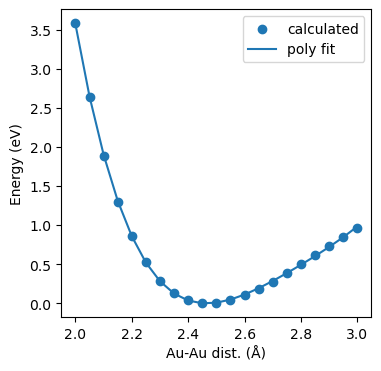

In [38]:
plt.figure(figsize=(4,4))

plt.scatter(d, energy-eopt, label='calculated')
plt.plot(d, np.polyval(poly, d)-eopt, label='poly fit')

plt.xlabel('Au-Au dist. (Å)')
plt.ylabel('Energy (eV)')
plt.legend()
plt.show()

### 3.2 Energy minimization
Given that we can compute energy and forces, we can optimize the atomic coordinates to find the mininum of the energy. In the `ase.optimize` sub-package you will find classes to perform various type of energy/enthalpy minimization, with and without costraints.

In [39]:
# let's create a simple Au nanocluster and randomize the atomic positions a bit
molecule = ase.Atoms('Au8', positions=[ [0,0,0], [3,0,0], [0,3,0], [0,0,3],
                                        [3,3,0], [3,0,3], [0,3,3], [3,3,3]] )

molecule.rattle(stdev=0.01)
#view(molecule)

In [40]:
# attach EMT calculator
molecule.calc = EMT()
print('initial energy:', molecule.get_potential_energy())

initial energy: 12.588029328943206


In [41]:
from ase.optimize import BFGS, FIRE

#minimizer = BFGS(molecule, trajectory='Au8.traj')
minimizer = FIRE(molecule, trajectory='Au8.traj')

minimizer.run(fmax=1e-3)
print('Final energy:', molecule.get_potential_energy())
ase.io.write('Au8.xyz', molecule)


      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 09:59:38       12.588029*       3.0343
FIRE:    1 09:59:38       11.870304*       3.0274
FIRE:    2 09:59:38       10.452591*       2.9420
FIRE:    3 09:59:38        8.865481*       2.6782
FIRE:    4 09:59:38        7.479938*       2.2110
FIRE:    5 09:59:38        6.450343*       1.4417
FIRE:    6 09:59:38        5.987300*       0.2618
FIRE:    7 09:59:38        6.366670*       1.7526
FIRE:    8 09:59:38        6.314724*       1.6210
FIRE:    9 09:59:38        6.226075*       1.3758
FIRE:   10 09:59:38        6.125576*       1.0477
FIRE:   11 09:59:38        6.039244*       0.6734
FIRE:   12 09:59:38        5.986740*       0.2882
FIRE:   13 09:59:38        5.977245*       0.1138
FIRE:   14 09:59:38        5.977192*       0.1124
FIRE:   15 09:59:38        5.977089*       0.1097
FIRE:   16 09:59:38        5.976941*       0.1057
FIRE:   17 09:59:38        5.976755*       0.1004
FI

FIRE:  162 09:59:38        4.952033*       0.0013
FIRE:  163 09:59:38        4.952033*       0.0011
FIRE:  164 09:59:38        4.952032*       0.0009
Final energy: 4.952032444265898


### 3.3 Molecular dynamics
**Molecular dynamics (MD)** is the next thing to do. In MD we integrate the Newton equations of motion of a system of particles while sampling a **thermodynamic** ensemble. This can be **micro-canonic (NVE)**(i.e. constant energy), **canonic (NVT)** (i.e. constant temperature), **isothermal-isobaric (NPT)** (i.e. constant temperature and pressure).

* The main purpose of MD is to evaluate physical properties at finite T (and P) from the time average of the istantaneous values.
* An other purpose of MD is to explore the mechanism of phase transitions, chemical reactions, etc..
* MD can be use also to attempt to find the global miniminum of the energy of a system. 

Let's start with a piece of gold and let's perform 1000 steps in the NVT ensemble, then 1000 steps in the NVE ensemble.

In [42]:
# let's import some packages
import ase.build
from ase.calculators.emt import EMT
from ase import units
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary

# let's create a piece of Au and attach the EMT calculator
au_cube = ase.build.bulk('Au', cubic=True) * [3, 3, 3]
print("number of atoms:", len(au_cube))
au_cube.calc = EMT()
au_cube.rattle(0.002)

# Initialize the velocities to T=300K
temperature = 300
MaxwellBoltzmannDistribution(au_cube, temperature_K=temperature)
Stationary(au_cube)   # remove the motion of the center of mass

number of atoms: 108


In [43]:
from ase.md.nvtberendsen import NVTBerendsen
from ase.md.verlet import VelocityVerlet
from ase.md import MDLogger
import os

In [44]:
# perform NVT run
time_step      = 0.5*units.fs     # 0.5 fs
taut           = 250*units.fs     # 250 fs
num_md_steps   = 1000
print_interval = 10

log_filename = 'MD-NVT.log'
traj_filename = 'MD-NVT.traj'
try:
    os.remove(log_filename)
    os.remove(traj_filename)
except:
    pass

print('===== NVT =====')
dyn = NVTBerendsen(au_cube, time_step, temperature, taut=taut, trajectory = traj_filename, 
                   logfile='-', loginterval=print_interval)

logger = MDLogger(dyn, au_cube, log_filename, header=True, stress=True, peratom=False, mode='a')
dyn.attach(logger, interval=print_interval)
status = dyn.run(num_md_steps)

===== NVT =====
Time[ps]      Etot[eV]     Epot[eV]     Ekin[eV]    T[K]
0.0000            5.159        0.284        4.875   349.2
0.0050            5.145        0.310        4.835   346.4
0.0100            5.133        0.387        4.746   340.0
0.0150            5.123        0.514        4.609   330.2
0.0200            5.116        0.688        4.429   317.2
0.0250            5.113        0.905        4.209   301.5
0.0300            5.115        1.160        3.955   283.3
0.0350            5.122        1.449        3.674   263.1
0.0400            5.135        1.763        3.372   241.6
0.0450            5.155        2.096        3.059   219.1
0.0500            5.180        2.436        2.744   196.5
0.0550            5.212        2.776        2.436   174.5
0.0600            5.249        3.104        2.146   153.7
0.0650            5.293        3.410        1.882   134.8
0.0700            5.341        3.686        1.654   118.5
0.0750            5.393        3.924        1.469   105.3

In [45]:
# perform NVE run
time_step      = 0.5*units.fs     # 0.5 fs
num_md_steps   = 1000
print_interval = 10

log_filename = 'MD-NVE.log'
traj_filename = 'MD-NVE.traj'
try:
    os.remove(log_filename)
    os.remove(traj_filename)
except:
    pass

print('===== NVE =====')
dyn = VelocityVerlet(au_cube, time_step, trajectory = traj_filename, 
                     logfile='-', loginterval=print_interval)

logger = MDLogger(dyn, au_cube, log_filename, header=True, stress=True, peratom=False, mode='a')
dyn.attach(logger, interval=print_interval)
status = dyn.run(num_md_steps)

===== NVE =====
Time[ps]      Etot[eV]     Epot[eV]     Ekin[eV]    T[K]
0.0000            7.258        3.434        3.824   273.9
0.0050            7.258        3.487        3.770   270.1
0.0100            7.258        3.542        3.715   266.1
0.0150            7.258        3.598        3.660   262.2
0.0200            7.258        3.652        3.605   258.3
0.0250            7.258        3.705        3.553   254.5
0.0300            7.258        3.755        3.502   250.9
0.0350            7.258        3.803        3.454   247.5
0.0400            7.258        3.847        3.410   244.3
0.0450            7.258        3.888        3.370   241.4
0.0500            7.258        3.924        3.334   238.8
0.0550            7.258        3.955        3.303   236.6
0.0600            7.258        3.980        3.278   234.8
0.0650            7.258        3.999        3.258   233.4
0.0700            7.258        4.012        3.245   232.5
0.0750            7.258        4.019        3.239   232.0

In [46]:
# let's plot the log files
nvt = np.loadtxt('MD-NVT.log', skiprows=1)
last_nvt = nvt[-1,0]
nve = np.loadtxt('MD-NVE.log', skiprows=1)

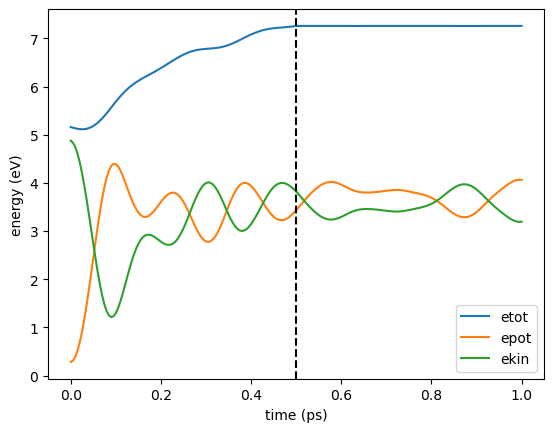

In [47]:
fig = plt.figure()

# total energy
plt.plot(nvt[:,0], nvt[:,1], color='C0', label='etot')
plt.plot(nve[:,0]+last_nvt, nve[:,1], color='C0')

# potential energy
plt.plot(nvt[:,0], nvt[:,2], color='C1', label='epot')
plt.plot(nve[:,0]+last_nvt, nve[:,2], color='C1')

# kinetic energy
plt.plot(nvt[:,0], nvt[:,3], color='C2', label='ekin')
plt.plot(nve[:,0]+last_nvt, nve[:,3], color='C2')

plt.axvline(last_nvt, color='black', linestyle='dashed')
plt.legend()
plt.xlabel('time (ps)')
plt.ylabel('energy (eV)')

plt.show()

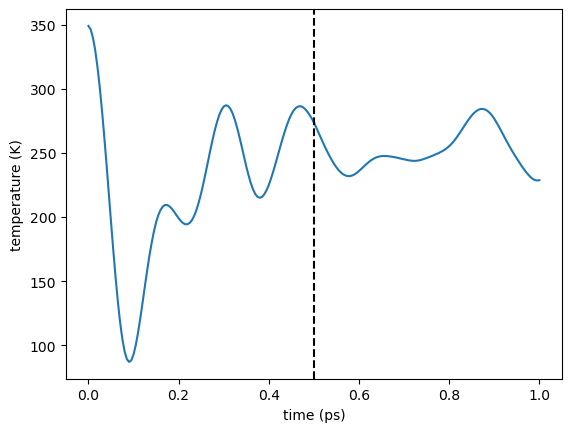

In [48]:
fig = plt.figure()

# temperature
plt.plot(nvt[:,0], nvt[:,4], color='C0', label='temp')
plt.plot(nve[:,0]+last_nvt, nve[:,4], color='C0')

plt.axvline(last_nvt, color='black', linestyle='dashed')
plt.xlabel('time (ps)')
plt.ylabel('temperature (K)')

plt.show()

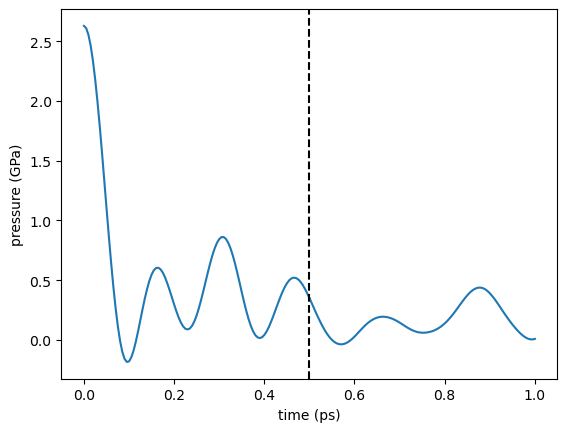

In [49]:
def press(data):
    return (data[:,5]+data[:,6]+data[:,7]) / 3.0

fig = plt.figure()

# temperature
plt.plot(nvt[:,0], press(nvt), color='C0', label='temp')
plt.plot(nve[:,0]+last_nvt, press(nve), color='C0')

plt.axvline(last_nvt, color='black', linestyle='dashed')
plt.xlabel('time (ps)')
plt.ylabel('pressure (GPa)')

plt.show()